### 1.1 Multi-armed bandits: 3 restaurants

In [487]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import random
%matplotlib inline

Here we have a setup discussed on [YouTube](https://www.youtube.com/watch?v=e3L4VocZnnQ) about a visiting professor spending 300 days in a new town. The professor wants to optimise their dining enjoyment of three restaurants. R1, R2 and R3. Each resturant will give an 'average' satisfaction for a meal with some distribution. The goal is to maximise the professors enjoyment and minimise their regret.

I'm choosing this as it's similar enough to the 10-armed bandit problem that the epsilon-greedy approaches can be looked at, but it is small enough that all the steps should be easy to follow

In [484]:
def restaurants():
    """
    Graph the probability distributions of the three restaurants based on the video
    """
    
    m=[10,8,5] #Mean for each of the 3 restaurants
    s=[5,4,2.5] #Standard deviation for each of the 3 restaurants
    
    rest=['Restaurant 1', 'Restaurant 2', 'Restaurant 3']
    colour=['gold','firebrick','mediumpurple']
    nrows=1
    ncols=int(len(rest)/nrows)
    fig, ax2d=plt.subplots(nrows,ncols)
    fig.set_size_inches(12,3)
    fig.subplots_adjust(wspace=0.4)
    ax=np.ravel(ax2d)
    
    for count, r in enumerate(rest):
        mu=m[count]
        sigma=s[count]
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax[count].plot(x, stats.norm.pdf(x, mu, sigma),color=colour[count])
        ax[count].set_title(rest[count])

def show_all_three():
    """
    Graph the probability distributions of the three restaurants together
    """
    m=[10,8,5] #Mean for each of the 3 restaurants
    s=[5,4,2.5] #Standard deviation for each of the 3 restaurants
    
    rest=['Restaurant 1', 'Restaurant 2', 'Restaurant 3']
    colour=['gold','firebrick','mediumpurple']
    for count, r in enumerate(rest):
        x=np.linspace(m[count] - 3*s[count], m[count] + 3*s[count], 100)
        plt.plot(x, stats.norm.pdf(x, m[count], s[count]),color=colour[count],label=rest[count])
    
    plt.xlabel("Satisfaction")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
        
def visit(r):
    """
    Return a value for the happiness after a visit based on the restaurant's probability distributions
    """
    r=r-1
    m=[10,8,5] #Mean for each of the 3 restaurants
    s=[5,4,2.5] #Standard deviation for each of the 3 restaurants
    
    # Generate numbers consistent with the distributions provided
    #nsample=1000 #1000 points made up this distribution
    #r1=np.random.normal(m[0],s[0],nsample)
    #r2=np.random.normal(m[1],s[1],nsample)
    #r3=np.random.normal(m[2],s[2],nsample)
    
    op=np.random.normal(m[r],s[r])
    return(op)
    

Here we have the distributions of satisfactions for each restaurant. Restaurant 1 has an average satisfaction of 10, with a standard deviation of 5. Restaurant 2 has an average satisfaction of 8, with a standard deviation of 4. Restaurant 3 has an average satisfaction of 5, with a standard deviation of 2.5.

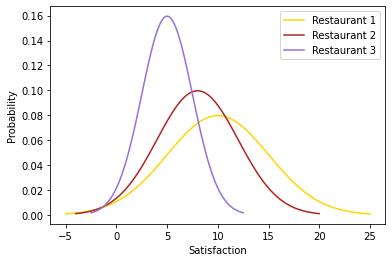

In [9]:
show_all_three()

### 1.2 Purely Explorative

In this example the professor will split their time between the three restaurants. So if they are visiting for 300 days, they will visit each of the three restaurants, 100 times each.

In [73]:
#Set the initial satisfaction to be 0
explore = np.zeros(3)
satisfaction=0
nrest=3
ndaystot=300
nvisits=int(ndaystot/nrest)
for r in range(1,4,1): #Each of the 3 restaurants
    for i in range(nvisits): #number of visits to each restaurant
        satisfaction=satisfaction+visit(r)
        explore[r-1] += 1
print(f'The satisfaction using a purely explorative method is {round(satisfaction)}')
print(explore)

The satisfaction using a purely explorative method is 2250
[100. 100. 100.]


### 1.3 Purely Exploitative

In this example the professor visits each of the restaurants only once and based on that one visit decides to exclusively frequent the one which gave them the highest satisfaction score on that first visit.
This is known as an exploitative search as you are exploiting the knowledge you already have from one visit to each restaurant to decide on where you will eat. 
The downside to this is that the satisfaction from each restaurant is derived from a distribution, and looking at the distributions of all three, we can see there is overlap between them all.
Restaurant 1 (yellow in the diagram) has the highest mean, but a large standard deviation. Restaurant 1 will not always give you the greatest satisfaction, it depends on where in the distribution the visit samples from.


In [76]:
satisfaction=0
exploit=np.zeros(3)
iscore=[] #Initial score for the restaurant
rest=['Restaurant 1', 'Restaurant 2', 'Restaurant 3']
for r in range(1,4,1):
    iscore.append(visit(r))
    exploit[r-1] += 1
bestrest=iscore.index(max(iscore))
satisfaction=max(iscore)
print(f'Based on a single visit to each; the professor will exclusively dine at '
      f'{rest[bestrest]} which '
      f'gave a satisfaction value of {round(satisfaction,2)}')
print(exploit)
print(bestrest)


# The professor will now visit the resaurant that made the favourable first impression for the 
# rest of their visit
nvisits=ndaystot-nrest

for i in range(nvisits):
    satisfaction=satisfaction+visit(bestrest)
    exploit[bestrest-1] += 1
print(f'The overall satisfaction using a purely exploitative method is {round(satisfaction)}')
print(exploit)

Based on a single visit to each; the professor will exclusively dine at Restaurant 2 which gave a satisfaction value of 13.88
[1. 1. 1.]
1
The overall satisfaction using a purely exploitative method is 2948
[298.   1.   1.]


### 1.4 Epsilon Greedy

In the epsilon greedy example, we try to balance the desire to explore (to get to know the distributions of the three restaurants sufficiently well) with the desire to exploit (to go to the restaurant that will give us the greatest satisfaction).
The process here, is to pick a value of epsilon (say 10%) and for that percentage of the time of the professor's visit, they will pick a restaurant at random. For the other 90% of the time in this case, they will visit the restaurant that they have calculated will give them the greatest satisfaction. Now this calculation may change after more visits to the three restaurants give a more realistic idea of their satisfaction.
As with the exploitative method, we do need to start with one visit to each restaurant. 

In [6]:
def first_visits():
    """
    A function to visit the three restaurants once each and return the number of the
    restaurant with the highest satisfaction after one visit
    """
    iscore=[] #Initial score for the restaurant
    summary =[None]*3 #Summary of the results for the 3 restaurants
    for r in range(1,4,1):
        vis=visit(r)
        iscore.append(vis)
        summary[r-1]=vis
        
    bestrest=iscore.index(max(iscore))
    r1=[]; r2=[]; r3=[]
    r1.append(summary[0]); 
    r2.append(summary[1]); 
    r3.append(summary[2])
    return(bestrest, r1, r2, r3)

In [11]:
# Set a value for epsilon
epsilon=10

best, r1, r2, r3 = first_visits()
satisfaction=r1[0]+r2[0]+r3[0]
print(f"Based on one visit, the best restaurant is Restaurant #{best+1}")
print(f"The scores are: {round(r1[0],2)}, {round(r2[0],2)}, {round(r3[0],2)}")
print(f"The total satisfaction after the inital 3 visits is {round(satisfaction)}")

ndaystot=300
nvisits=ndaystot-3
results=[None]*3
# Now the professor has 297 days to either explore or exploit. There is a epsilon percent
# chance that on any given day the professor will visit a random restaurant and not
# necessarily the best restaurant based on their current information
for i in range(nvisits):
    ep_tst=random.random()
    if (ep_tst < epsilon/100.): # If a random number between 0 and 1 is below 0.1 then
        # Pick a random restaurant (between 0 and 2) and add the score to the list
        rest=random.randrange(0,3)
        val=visit(rest)
        if rest == 0:
            r1.append(val)
        if rest == 1:
            r2.append(val)
        if rest == 2:
            r3.append(val)
        # Work out the averages of each list and pick the restaurant with the highest
        # average rating
        averages=[np.mean(r1),np.mean(r2),np.mean(r3)]
        best=averages.index(max(averages))
    else:
        val=visit(best)
        if best == 0:
            r1.append(val)
        if best == 1:
            r2.append(val)
        if best == 2:
            r3.append(val)
        averages=[np.mean(r1),np.mean(r2),np.mean(r3)]
        best=averages.index(max(averages)) 
    satisfaction=satisfaction+val
    
print(f"At the end of their visit, the professor thinks Restaurant #{best+1} is the best")
print(f"The professor visited restaurant #1 {len(r1)} times, Restaurant #2 {len(r2)} times and Restaurant #3 {len(r3)} times")
print(f"Their satisfaction was {round(satisfaction)} using the epsilon-greedy method with epsilon = {epsilon}%")

Based on one visit, the best restaurant is Restaurant #2
The scores are: 3.18, 5.51, -3.04
The total satisfaction after the inital 3 visits is 6
At the end of their visit, the professor thinks Restaurant #2 is the best
The professor visited restaurant #1 7 times, Restaurant #2 280 times and Restaurant #3 13 times
Their satisfaction was 2840 using the epsilon-greedy method with epsilon = 10%


### 1.5 Analysis

So what can we say about the number of times the optimal restaurant was picked. (Where we define optimal as the restaurant with the highest mean satisfaction, therefore is Restaurant 1)?

In [485]:
#Put it all together
# Explore
def explore():
    explore=np.zeros(3)
    satisfaction=0
    for _ in range(300):
        rd = random.random()
        if rd < 1/3:
            explore[0] += 1
            satisfaction = satisfaction + visit(1)
        if 1/3 <= rd <= 2/3:
            explore[1] += 1
            satisfaction = satisfaction + visit(2)
        if rd > 2/3:
            explore[2] += 1
            satisfaction = satisfaction + visit(3)
    percent=100*(explore[0]/sum(explore))
    print(f'The satisfaction using a purely explorative method is {round(satisfaction)}')
    print(f'The optimal restaurant was picked {round(percent,2)}% of the time.')

def exploit():
    exploit=np.zeros(3)
    first_visit=np.zeros(3)
    satisfaction=0
    for _ in range(3):
        satisfaction = satisfaction + visit(_+1)
        first_visit[_] = satisfaction
        exploit[_] += 1
    best_one_vis=np.argmax(first_visit)
    print(best_one_vis, first_visit)
    for _ in range(297):
        satisfaction = satisfaction + visit(best_one_vis-1)
        exploit[best_one_vis] +=  1
    print(first_visit)
    print(exploit)
    
    print(f'The satisfaction using a purely explorative method is {round(satisfaction)}')
    print(f'The optimal restaurant was picked {round(percent,2)}% of the time.')

In [486]:
explore()
exploit()

The satisfaction using a purely explorative method is 2215
The optimal restaurant was picked 33.0% of the time.
2 [16.6022325  20.05089009 24.9115203 ]
[16.6022325  20.05089009 24.9115203 ]
[  1.   1. 298.]
The satisfaction using a purely explorative method is 2945
The optimal restaurant was picked 33.0% of the time.
